## How to Clone from Portal for ArcGIS to ArcGIS Online

Procedure:

##### Clone individual feature services
1. Sign in Portal for ArcGIS (**Source)
2. Sign in ArcGIS Online (**Target)
3. Create helper functions
4. Extract only hosted feature services from the **source
5. Clone the feature services from source to **target
6. Check the feature services cloned in the **target

##### Clone Web Maps and Operations Dashboard and associated hosted feature services
##### Note that non-hosted feature services cannot be cloned.

Reference: https://developers.arcgis.com/python/guide/cloning-content/
https://support.esri.com/en/technical-article/000018924

In [1]:
from pathlib import Path
import sys

from arcgis.gis import GIS, Item
from arcgis.env import active_gis
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap

In [4]:
# 1. Sign in Source (Portal)
source = GIS("https://mmspgc-gis.mmspgc.local/portal", "matsuzakieiji", "timberland12345", verify_cert = False)

In [2]:
# Sign in Target (ArcGIS Online)
target = GIS("https://arcgis.com", "eijimatsuzaki1", "timberland12345", verity_cert=False)

In [5]:
active_gis = source

In [6]:
def get_user_items(user, active_gis):
    user_inventory = {}
    user_items = active_gis.content.search(query=f"* AND owner:{user.username}", 
                                           max_items=500)
    for item in user_items:
        if item.type not in user_inventory:
            user_inventory[item.type] = [i 
                                         for i in user_items 
                                         if i.type == item.type]
    return user_inventory

In [7]:
def print_user_inventory(inventory):
    for itype, ilist in inventory.items():
        try:
            print(f"{itype}\n{'-'*50}")
            for i in ilist:
                print(f"{' ':3}{i.title:50}")
            print("\n")
        except Exception as e:
            print(f"\t\tOperation failed on: {i.title}")
            print(f"\t\tException: {sys.exc_info()[1]}")
            continue           

In [8]:
def get_fs_webmaps(fs, inv):
    fs_webmap_inventory = {}
    fs_inv = []
    try:
        for wm in inv['Web Map']:
            if fs.id in get_layer_item_ids(wm):
                if not wm in fs_inv:
                    fs_inv.append(wm)
        fs_webmap_inventory[fs.title] = fs_inv
        return fs_webmap_inventory
    except KeyError as ke:
        pass

In [9]:
def get_layer_item_ids(wm):
    wmo = WebMap(wm)
    wm_id_list = []
    for layer in wmo.layers:
        try:
            fsvc = FeatureLayerCollection(layer['url'][:-1], active_gis)
            if not fsvc.properties['serviceItemId'] in wm_id_list:
                wm_id_list.append(fsvc.properties['serviceItemId'])
        except Exception as e:
            pass
    return wm_id_list

In [10]:
def get_dash_wm(dash):
    return [active_gis.content.get(widget['itemId']) 
            for widget in dash.get_data()['widgets'] 
            if widget['type'] == "mapWidget"]

In [11]:
source_admin_inventory = get_user_items(source.users.me, source)

In [12]:
print_user_inventory(source_admin_inventory)

Geoprocessing Service
--------------------------------------------------
   RasterUtilities                                   
   PrintingTools                                     
   GeocodingTools                                    
   OfflinePackaging                                  


Map Service
--------------------------------------------------
   Demolition_Plan_Test                              
   Priority                                          
   Valenzuela Station                                
   Muncipality_Boundary_Parcellary_N2                
   AsBuilt_N2                                        
   Contours_Clip                                     
   sampleViaductMerged                               
   Priority for NVS                                  
   Stations                                          
   Viaduct Sample                                    
   Depot Building                                    
   Lot Boundary                                     

In [13]:
for item_type in list(source_admin_inventory.keys()):
    print(item_type)

Geoprocessing Service
Map Service
Web Scene
Symbol Set
Service Definition
Project Template
Feature Service
Data Store
Web Mapping Application
Image
Dashboard
Site Application
Web Map
Scene Service
WMS
Image Service
Geometry Service
Map Package
Microsoft Excel
Task File
Code Attachment


### Feature Services (Hosted)

Clone hosted feature services. Please note that non-hosted feature services (i.e., registered feature services) cannot be cloned.
###### If web maps or operations dashboard is cloned, skip this process

In [14]:
# Extract only hosted feature layer from Feature Service
hosted_fsvc = [fs 
               for fs in source_admin_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

In [15]:
hosted_fsvc

[<Item title:"Creek_PO" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"OBS_River" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"MonitorBuildingPoint" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"TBM_Centerline_Zvalue" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"TBM_Spot" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"Geotech_TSS" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"Find_Locations_in_Process" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"TBM_segmentedLine" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"Summarize_Parcellary_Boundary_within_Municipality_Boundary" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"TBM_Manufacture_Progress" type:Table Layer owner:matsuzakieiji>, <Item title:"OBS_Abutment" type:Feature Layer Collection owner:matsuzakieiji>, <Item title:"GeoTechSpot" type:Feature Layer Collection owner:

In [16]:
# Clone selected hosted feature layer from source to target
for hfs in hosted_fsvc:
    try:
        if hfs.ownerFolder:
            folder = next((f['title'] 
                          for f in source.users.me.folders 
                          if f['id'] == hfs.ownerFolder))
            if not folder in [fld['title']
                              for fld in target.users.me.folders]:
                target.content.create_folder(folder=folder)
            print(f"Cloning {hfs.title}...")
            clone_fs = target.content.clone_items([hfs], folder=folder)
            print(f"...completed")
        else:
            print(f"Cloning {hfs.title}...")
            cloned_fs = target.content.clone_items([hfs])
            if not cloned_fs:
                print(f"{hfs.title} not cloned")
            else:
                print(f"...completed")       
    except Exception as e:
        print(f"...Failed to Clone {hfs.title}...")
        print(f"\tException Type: {sys.exc_info()[0]}")
        print(f"\tException Value: {sys.exc_info()[1]}")
        print(f"\tException Traceback line: {sys.exc_info()[2].tb_lineno}")
        print(f"\tException Traceback instruction: {sys.exc_info()[2].tb_lasti}")
        continue

Cloning Creek_PO...
...completed
Cloning OBS_River...
...completed
Cloning MonitorBuildingPoint...
...completed
Cloning TBM_Centerline_Zvalue...
...completed
Cloning TBM_Spot...
...completed
Cloning Geotech_TSS...
...Failed to Clone Geotech_TSS...
	Exception Type: <class 'arcgis._impl.common._clone._ItemCreateException'>
	Exception Value: ('Failed to create Feature Service Geotech_TSS: list index out of range', <Item title:"Geotech_TSS" type:Feature Layer Collection owner:eijimatsuzaki1>)
	Exception Traceback line: 12
	Exception Traceback instruction: 116
Cloning Find_Locations_in_Process...
...completed
Cloning TBM_segmentedLine...
...completed
Cloning Summarize_Parcellary_Boundary_within_Municipality_Boundary...
...completed
Cloning TBM_Manufacture_Progress...
...completed
Cloning OBS_Abutment...
...completed
Cloning GeoTechSpot...
...completed
Cloning Excavation Spot...
...completed
Cloning OBS_Affected_Structures...
...completed


In [17]:
# Query the target to inspect the results of cloning the feature services
target_admin_inventory = get_user_items(target.users.me, target)

In [18]:
print_user_inventory(target_admin_inventory)

Service Definition
--------------------------------------------------
   PO_34_v2_tif                                      
   PO_SURF_2m1_tif                                   
   01_NVS Simplified_WFL1                            
   PO_SURF_2m1_reproject_tif                         
   PO Section Alignment and LAR                      
   Rail Sector Maps_WFL1                             
   World Imagery _for Export__062DDF47_DF27_4261_9D11_D2EB33D7CBD2_tpk
   TestImage                                         
   Civil_EIJI_TBM_Manufacture_1                      
   PO_1_2_TIF                                        


Vector Tile Service
--------------------------------------------------
   Nova (No Buildings)                               
   Nova                                              
   OpenStreetMap (WGS84-NoBuildings)                 
   World Street Map (Night)                          
   World Street Map (Night-NoBuilding-NoSmallStrees) 
   Dark Gray Canvas Nobuilding

In [15]:
# Check feature services ID cloned between source and target
target_to_source = {}
for targ_fsvc_item in target_admin_inventory['Feature Service']:
    for keyword in targ_fsvc_item.typeKeywords:
        if 'source' in keyword:
            source_id = keyword.split('-')[1]
            try:
                flyr = source.content.get(source_id)
                target_to_source[targ_fsvc_item.title] = (keyword,
                                                          flyr.title,
                                                          flyr.id)
            except Exception as e:
                pass
for trg_item, src_item in target_to_source.items():
    print(f"Target Item: {trg_item:45}{src_item[0]}\n{' '*2}"
          f"Source Item: {src_item[1]:45}{src_item[2]}")
    print("\n")

Target Item: Summarize_Parcellary_Boundary_within_Municipality_Boundarysource-3942c9991c2045fdb00de87237460cc5
  Source Item: Summarize_Parcellary_Boundary_within_Municipality_Boundary3942c9991c2045fdb00de87237460cc5


Target Item: TBM_Manufacturing_ProgressCurve_summary      source-2e9df6e6243b4d96b2b5b786fc29f799
  Source Item: TBM_Manufacturing_ProgressCurve_summary      2e9df6e6243b4d96b2b5b786fc29f799


Target Item: GeoTechSpot                                  source-aae2ce08a9724807babd5e811b80f0dc
  Source Item: GeoTechSpot                                  aae2ce08a9724807babd5e811b80f0dc


Target Item: TBM_Centerline_Zvalue                        source-fa7aad7fd11d401a9911c8b261784980
  Source Item: TBM_Centerline_Zvalue                        fa7aad7fd11d401a9911c8b261784980


Target Item: MonitorBuildingPoint                         source-f390ff14dba74058b9922c85e793043b
  Source Item: MonitorBuildingPoint                         f390ff14dba74058b9922c85e793043b


Target It

In [18]:
# Examine the target feature services to see that we also created the folder structure
target_hosted_fsvc = [fs 
               for fs in target_admin_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

In [19]:
active_gis = target

In [20]:
print(f"{'Feature Layer':<33}{'Folder ID':<35}{'Folder Name':15}{'Item ID'}\n"
      f"{'-'*28:<30}{'-'*33:<35}{'-'*13:<15}{'-'*37}")
for hosted_fs in target_hosted_fsvc:
    try:
        fs_wm_maps = get_fs_webmaps(hosted_fs, target_admin_inventory)[hosted_fs.title]
    except TypeError as te:
        pass
        continue
    finally:
        if not hosted_fs.ownerFolder:
            print(f"{hosted_fs.title[:30]:33}{' ':35}{'Root Folder':15}{hosted_fs.id}")
            if fs_wm_maps:
                for wm in fs_wm_maps:
                    print(f"{' '*2}...consumed in {wm.title} web map")
            else:
                pass
        else:
            print(f"{hosted_fs.title[:30]:33}{hosted_fs.ownerFolder:35}"
                  f"""{next(f['title'] for f in target.users.me.folders 
                   if f['id'] == hosted_fs.ownerFolder):15}"""
                  f"{hosted_fs.id}")
            if fs_wm_maps:
                for wm in fs_wm_maps:
                    print(f"{' '*2}...consumed in {wm.title} web map")
            else:
                pass
        print("\n")

Feature Layer                    Folder ID                          Folder Name    Item ID
----------------------------  ---------------------------------  -------------  -------------------------------------
Summarize_Parcellary_Boundary_   e0beb38cc1c64124b3e76d190e766629   NSCR-Ex N2     4fe9ceae05014e9891253b92dceca9c0


TBM_Manufacturing_ProgressCurv   44bb62c88708479aa3496a8f8caa8897   MMSP_Civil     5f0338048d5249669465cd90abdc55f9


GeoTechSpot                      44bb62c88708479aa3496a8f8caa8897   MMSP_Civil     ac2acec6635844d1b49dd27f0679590e


TBM_Centerline_Zvalue            44bb62c88708479aa3496a8f8caa8897   MMSP_Civil     79d65648dcbc40c8b9cf8429540d50f3


MonitorBuildingPoint             44bb62c88708479aa3496a8f8caa8897   MMSP_Civil     b896be37b46743dd88fe678d1ba27719


TBM_Spot                         44bb62c88708479aa3496a8f8caa8897   MMSP_Civil     917cd229de214ea3aec5146a9b17caa3


Excavation Spot                  44bb62c88708479aa3496a8f8caa8897   MMSP_Civil     

### Web Maps

Clone Web Maps and hosted feature services consumed in the web maps.
NOTE: non-hosted feature services (e.g., registered feature services) are not cloned but only reference.
      This means that you need to sign in the Portal for ArcGIS when web maps makes a reference to the
      the registered feature services.

In [16]:
# Look at the Web Maps in our source organization
for wm in source_admin_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(wm_obj.item.title)

01-Status_Properties for Acquisition
01-NVS Simplified-Priority1
01-NVS Simplified
Payment Processing and Expropriation Cases
TBM_Segment
BingMaps
World Street Map Night No Buildings
OtB Preparation and OtB Delivered
TBM_Manufacture
01-Status_NVS2_PaymentProcessing
Status of OtB and OtC
Rail Sector Maps
TBM_Location
01-Status_NVS


In [ ]:
# Inpsect what layers are in each Web Map

In [17]:
def is_hosted(item):
    return [keyword for keyword in item.typeKeywords if "Hosted" in keyword]

In [18]:
def print_webmap_inventory(wm):
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        try:
            if is_hosted(Item(active_gis, wm_layer['itemId'])):
                print(f"{' '*2}{wm_layer['title']:40}HOSTED{' ':5}"
                      f"{wm_layer['layerType']:20}{dict(wm_layer)['itemId']}")
            else:
                print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                      f"{wm_layer['layerType']:20}{wm_layer.id}") 
        except:
            print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                  f"{wm_layer['layerType']:20}{wm_layer.id}")
    print("\n")

In [19]:
# Remember to set the active_gis variable when using the helper functions
active_gis = source

In [20]:
# This helper function may also freeze.
for wm in source_admin_inventory['Web Map']:
    print_webmap_inventory(wm)

01-Status_Properties for Acquisition
----------------------------------------------------------------------------------------------------
  Proposed Drainage Pipe                  other      ArcGISFeatureLayer  Drainage_DP_1637
  PO Section                              other      ArcGISFeatureLayer  PO_Section_5521
  EVS_Drawings                            other      ArcGISFeatureLayer  EVS_Drawings_1468
  EVS Boundary                            other      ArcGISFeatureLayer  Boundary_6622_4603
  BSS                                     other      ArcGISFeatureLayer  Boundary_6622_3600
  Construction Boundary                   other      ArcGISFeatureLayer  Boundary_6622
  Target Plan for Map Series              other      ArcGISFeatureLayer  Target_Plan_for_Map_Series_9858
  Target_Plan_Schedule                    other      ArcGISFeatureLayer  Target_Plan_Schedule_5428
  Creek                                   HOSTED     ArcGISFeatureLayer  8ae1414fecbd413fa96038d146c5c73f
  Tandang S

In [26]:
# Use helper functions to return a list of the unique itemId values consumed in each web map
for wm in source_admin_inventory['Web Map']:
    print(f"{wm.title}\n{'-'*80}")
    for item_id in get_layer_item_ids(wm):
        print(f"{' '*2}{item_id}")
    print("\n")

TBM_Manufacture
--------------------------------------------------------------------------------


01-Status_NVS2_PaymentProcessing
--------------------------------------------------------------------------------
  8ae1414fecbd413fa96038d146c5c73f


Rail Sector Maps
--------------------------------------------------------------------------------


Status of OtB and OtC
--------------------------------------------------------------------------------


TBM_Location
--------------------------------------------------------------------------------
  9068ec49a80d46a18a667450e12cc870


01-Status_NVS
--------------------------------------------------------------------------------
  8ae1414fecbd413fa96038d146c5c73f


01-Status_Properties for Acquisition
--------------------------------------------------------------------------------
  8ae1414fecbd413fa96038d146c5c73f


01-NVS Simplified-Priority1
--------------------------------------------------------------------------------
  8ae1414fecbd413f

In [21]:
# Clone web maps
## If item ID exists in the web maps, it will use ones in target. If item ID does not exist, it will clone the item.
## For non-hosted items, it will recreate those items in the resulting web map.
wm_map = {}
for wm in source_admin_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*50}")
    if wm_obj.item.ownerFolder:
        folder_name = [f['title'] for f in source.users.me.folders 
                       if f['id'] == wm_obj.item.ownerFolder][0]
        try:
            print(f"...cloning {wm_obj.item.title}")
            cloned_wm = target.content.clone_items(items=[wm_obj.item], 
                                              folder=folder_name)          
            wm_map[wm.id] = cloned_wm[0].id
            print(f"...completed")
            print(f"\n")
        except Exception as e:
            print(f"....failed to clone {wm_obj.item.title}")
            print(str(e))
            print(f"\n")

01-Status_Properties for Acquisition
--------------------------------------------------
...cloning 01-Status_Properties for Acquisition
...completed


01-NVS Simplified-Priority1
--------------------------------------------------
...cloning 01-NVS Simplified-Priority1
...completed


01-NVS Simplified
--------------------------------------------------
...cloning 01-NVS Simplified
...completed


Payment Processing and Expropriation Cases
--------------------------------------------------
...cloning Payment Processing and Expropriation Cases
....failed to clone Payment Processing and Expropriation Cases
list index out of range


TBM_Segment
--------------------------------------------------
...cloning TBM_Segment
....failed to clone TBM_Segment
list index out of range


BingMaps
--------------------------------------------------
World Street Map Night No Buildings
--------------------------------------------------
OtB Preparation and OtB Delivered
-----------------------------------------

In [22]:
# Examine the resulting Web Map items in the target
target_admin_inventory = get_user_items(target.users.me, target)

In [23]:
active_gis = target

In [24]:
for wm in target_admin_inventory['Web Map']:
    print_webmap_inventory(wm)

TBM_Manufacture
----------------------------------------------------------------------------------------------------
  Stations                                other      ArcGISFeatureLayer  Stations_6343
  Boundary                                other      ArcGISFeatureLayer  Boundary_6723
  TBM_Alighnment                          other      ArcGISFeatureLayer  TBM_Alighnment_4641


Status of OtB and OtC
----------------------------------------------------------------------------------------------------
  Muncipality_Boundary_Parcellary_N2      other      ArcGISFeatureLayer  Muncipality_Boundary_Parcellary_N2_3321
  OtC AsBuilt                             other      ArcGISFeatureLayer  AsBuilt_N2_5798
  OtC AsBuilt - copy                      other      ArcGISFeatureLayer  AsBuilt_N2_5798_552
  AsBuilt Boundary                        other      ArcGISFeatureLayer  AsBuilt_N2_3225
  ROW                                     other      ArcGISFeatureLayer  Alignment_N2_7286
  Parcellary Bou

In [25]:
# Examine wm_map dictionary to see that we indeed have a dictionary mapping that has ids as
# both keys (source web map id) and values (target web map id).
wm_map

{'3f81684836e049f8a5734219b6fc7b83': '4cbbc202e3e24932960cdab9042d315b', '9062169ef6cc491c9683551c44b0c6d0': 'eb8c4c0f2c5d4b8d9daf06574da0aece', 'ab2b92d17d7342149c54f99e3aa41d9b': '880a4ce5e49846169635bc1b9dea7734', '2bead0d6d989440fbdc7fcd5b04134a1': 'b2a48a14583c422c9fb2a81274be358d', 'ef6ae541ccfd4683b279b4de7ffc0f12': 'd6d90cbbfa124b96b9df60fe77d09c65'}

In [ ]:
# Visually compare our web maps

In [29]:
# Source web map
source_webmap = WebMap(source.content.get(list(wm_map.keys())[1]))
source_webmap

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [31]:
# Target web map
target_webmap = WebMap(target.content.get(list(wm_map.values())[1]))
target_webmap

TypeError: item type must be web map

### ArcGIS Dashboards

Clone Operations Dashboard and associated hosted and other feature services

<Item title:"1-Properties for Land Acquisition (NVS)_Compiled" type:Dashboard owner:matsuzakieiji>
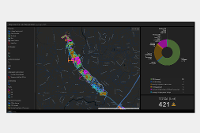

In [156]:
ops_dash = source_admin_inventory['Dashboard'][15]
ops_dash

In [157]:
active_gis = source

In [158]:
# Get Web Map used in the Operations Dashboard
dash_wm = get_dash_wm(ops_dash)[0]
dash_wm

IndexError: list index out of range

In [74]:
WebMap(dash_wm)

AttributeError: 'list' object has no attribute 'type'

In [152]:
dash_wm.id

'9062169ef6cc491c9683551c44b0c6d0'

In [153]:
print_webmap_inventory(dash_wm)

01-NVS Simplified-Priority1
----------------------------------------------------------------------------------------------------
  Proposed Drainage Pipe                  other      ArcGISFeatureLayer  Drainage_DP_1637
  PO Section                              other      ArcGISFeatureLayer  PO_Section_5521
  EVS_Drawings                            other      ArcGISFeatureLayer  EVS_Drawings_4758
  EVS Boundary                            other      ArcGISFeatureLayer  Boundary_6622_4603
  BSS                                     other      ArcGISFeatureLayer  Boundary_6622_3600
  Construction Boundary                   other      ArcGISFeatureLayer  Boundary_6622
  Target Plan for Map Series              other      ArcGISFeatureLayer  Target_Plan_for_Map_Series_9858
  Target_Plan_Schedule                    other      ArcGISFeatureLayer  Target_Plan_Schedule_5428
  Creek                                   HOSTED     ArcGISFeatureLayer  8ae1414fecbd413fa96038d146c5c73f
  Tandang Sora Creek

In [154]:
# Query the web map object we created to see if this web map id was cloned.
wm_item_mapping = {src_wm:trg_wm for src_wm,trg_wm in wm_map.items()
                   if dash_wm.id == src_wm}
wm_item_mapping

{'9062169ef6cc491c9683551c44b0c6d0': 'eb8c4c0f2c5d4b8d9daf06574da0aece'}

In [155]:
# Clone Operations Dashboard
target.content.clone_items(items=[ops_dash],
                           folder="MMSP_LAR",
                           item_mapping=wm_item_mapping)

[<Item title:"01-NVS_Simplified_Priority1" type:Dashboard owner:eijimatsuzaki1>]